# Impacto de Meteorito

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Meteorite_Landings.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [2]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


### Investigar y explorar datos

In [3]:
df2 = df.dropna(subset=["mass", "year"])  # Eliminamos valores nan de cada una de esas columnas
df2 = df2[df2["mass"] > 0]  # Filtramos por la columna mass sea mayor estricto a cero

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45292 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45292 non-null  object 
 1   id           45292 non-null  int64  
 2   nametype     45292 non-null  object 
 3   recclass     45292 non-null  object 
 4   mass         45292 non-null  float64
 5   fall         45292 non-null  object 
 6   year         45292 non-null  float64
 7   reclat       38097 non-null  float64
 8   reclong      38097 non-null  float64
 9   GeoLocation  38097 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


Exploremos también los datos visualmente.

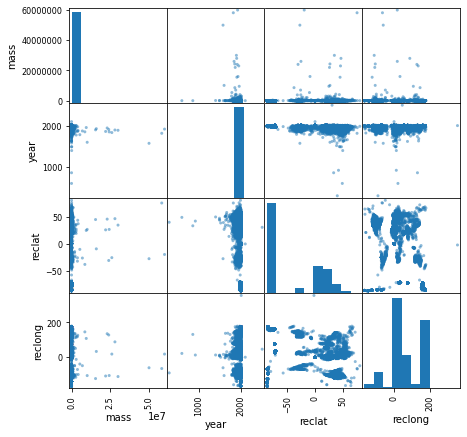

In [5]:
pd.plotting.scatter_matrix(df[["mass", "year", "reclat", "reclong"]], 
figsize=(7,7));

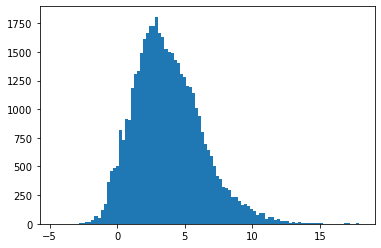

In [6]:
year = df2["year"]
masses = df2["mass"]
logmass = np.log(masses)
plt.hist(logmass, bins=100);

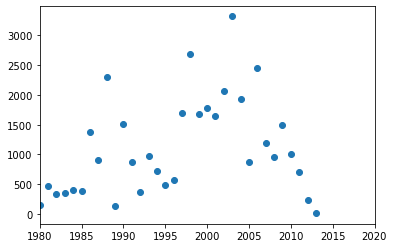

In [8]:
counts = year.value_counts()
plt.scatter(counts.index, counts)
plt.xlim(1980, 2020);

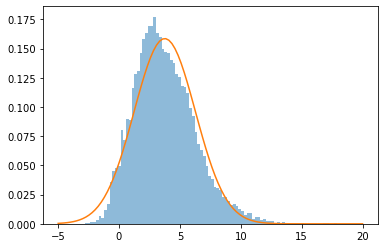

In [9]:
from scipy.stats import norm, skewnorm, lognorm
ms = np.linspace(-5, 20, 100)

mean, std = logmass.mean(), np.std(logmass)
pdf_norm = norm.pdf(ms, mean, std)
plt.hist(logmass, bins=100, density=True, alpha=0.5)
plt.plot(ms, pdf_norm);

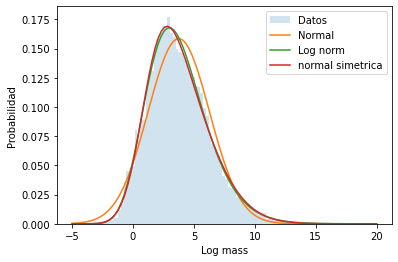

In [10]:
p_lognorm = lognorm.fit(logmass)
pdf_lognorm = lognorm.pdf(ms, *p_lognorm)

p_skewnorm = skewnorm.fit(logmass)
pdf_skewnorm = skewnorm.pdf(ms, *p_skewnorm)

plt.hist(logmass, bins=100, density=True, alpha=0.2, label="Datos")
plt.plot(ms, pdf_norm, label="Normal")
plt.plot(ms, pdf_lognorm, label="Log norm")
plt.plot(ms, pdf_skewnorm, label="normal simetrica");
plt.legend()
plt.xlabel("Log mass")
plt.ylabel("Probabilidad");

In [11]:
mass_of_doom = np.log((4/3) * np.pi * 500**3 * 1600 * 1000)  # Solo usando una aproximación esférica y algo de densidad promedio (formula del area de una esfera)
mass_of_doom

34.36175044077777

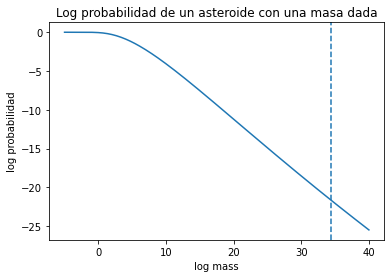

In [12]:
ms2 = np.linspace(-5, 40, 200)
plt.plot(ms2, lognorm.logsf(ms2, *p_lognorm))
plt.axvline(mass_of_doom, ls="--")
plt.xlabel("log mass")
plt.ylabel("log probabilidad")
plt.title("Log probabilidad de un asteroide con una masa dada");

Así que aquí tenemos la probabilidad de que un asteroide esté por encima de cierta masa cuando golpee la Tierra. Pero para responder a la pregunta "¿Cuál es la probabilidad de que uno o más asteroides de gran masa golpeen la Tierra en 1000 años?" tenemos que tener en cuenta el componente de tiempo real. Supongamos que en los próximos 1000 años, predecimos que habrá impactos de $N$.

$$P(>=1\ {\rm altamasa}) = 1 - P(0\ {\rm altamasa}) = 1 - P(N\ {\rm no\_altamasa}) = 1 - P({\rm no\_alta masa})^N$$

Imagine una pregunta similar: Probabilidad de no obtener seises en 5 tiradas. Bueno, es 
$$\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{ 6} = \left(\frac{5}{6}\right)^5 $$
La probabilidad de obtener uno o más seises es entonces $1 - (5/6)^5$.

Entonces, para dar un número, necesitamos calcular $N$ a partir de la tasa anual, la cantidad de años y nuestra eficiencia de detección y usar eso con la probabilidad de que cualquier impacto dado no sea de gran masa.

In [13]:
prob_small_mass = lognorm.logcdf(mass_of_doom, *p_lognorm)
frac_sky_monitored = 0.2
num_years = 1000
num_events = num_years * counts.max() / frac_sky_monitored
prob_bad = 1 - np.exp(num_events * prob_small_mass)
print(f"Prob un impacto de asteroide >1km con {num_years} años es {prob_bad * 100:.2f}%")

Prob un impacto de asteroide >1km con 1000 años es 0.67%
